Imports the CNN exported from 03-train-cnn-model and uses it with a sliding window to detect objects. The sliding window algorithm turns out to be really slow. Should look into the [You Only Look Once](https://arxiv.org/abs/1506.02640) algorithms to see if I can get significant speedups.

In [1]:
from collections import deque
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance,  ImageFont

import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.models import load_model

from functions.image.image_tools import pyramid, sliding_window

In [310]:
to_save = True
np.random.seed(42)

In [3]:
# check that gpu is being used
# see: https://stackoverflow.com/questions/63415922/how-to-know-if-keras-is-using-gpu-or-cpu
# failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error

print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16527690181020209052
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7831047481157429748
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7608998304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3155511336157482378
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13279452945005705320
physical_device_desc: "device: XLA_GPU device"
]
2.2.0
Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Get Data

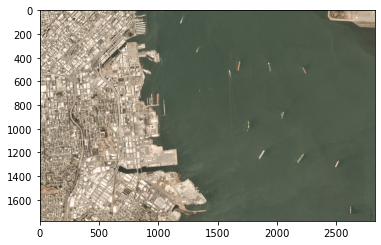

In [224]:
# load model
model = load_model('models/model.h5')
filename = 'sfbay_1'

# preview scene
scene = Image.open(f'data/scenes/scenes/{filename}.png')  # note: RGB-A, a=0 is transparent
scene_np = np.asarray(scene).astype('uint8')
scene_np = scene_np[0:1777, 0:2825, 0:3]  # remove alpha dimension
width, height, n_colors = scene_np.shape  # (1777, 2825, 3)

plt.imshow(scene_np)  # lightweight preview

# Windows

In [133]:
scene_np.shape

(1777, 2825, 3)

In [159]:
# note: halving the step_size quadruples the number of windows
# note: step_size=20 takes 4 minutes, step_size=10 takes 16 minutes

coordinates = []
i = 1
for x, y, window in tqdm(sliding_window(scene_np, step_size=20)):
    # default window_size is 80x80
    
    prediction = model.predict(np.array([window]))
    if prediction[:, 1] >= 0.5:
        coordinates.append((x, y))
        print(i, x, y)
        i+=1

2it [00:00, 13.09it/s]

num_it: 11730


3292it [01:06, 52.33it/s]

1 2180 460


3398it [01:09, 46.05it/s]

2 1560 480


8397it [02:50, 53.30it/s]

3 2160 1200


8823it [02:59, 50.52it/s]

4 2460 1260


11526it [03:54, 55.04it/s]

5 1260 1660
6 1280 1660
7 1300 1660


11730it [03:58, 49.11it/s]


# View Ships

In [261]:
coordinates

[(2180, 460),
 (1560, 480),
 (2160, 1200),
 (2460, 1260),
 (1260, 1660),
 (1280, 1660),
 (1300, 1660)]

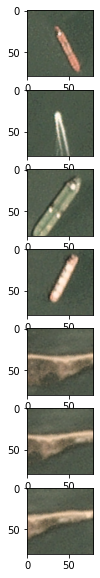

In [226]:
# model didn't perform well

window_width, window_height = 80, 80

fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(coordinates):
    plt.subplot(7, 1, 1+i)
    plt.imshow(scene_np[y:y+window_height, x:x+window_width])

# Draw Bounding Box

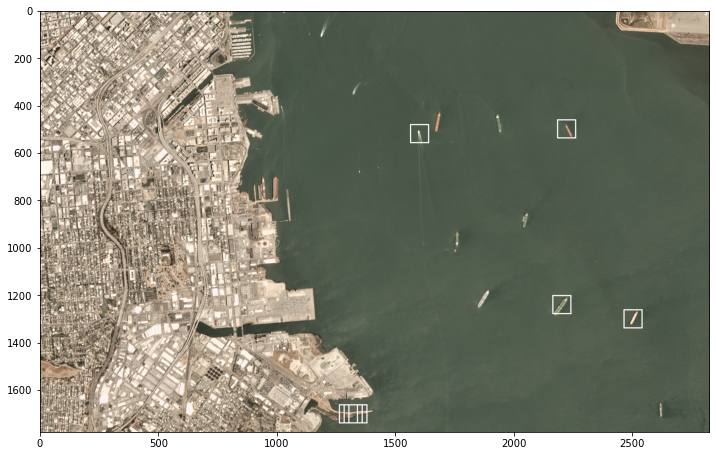

In [259]:
source_img = Image.open("data/scenes/scenes/sfbay_1.png")

for x, y in coordinates:
    draw = ImageDraw.Draw(source_img)
    draw.rectangle(((x, y), (x+window_height, y+window_height)), outline='white', width=5)
    
if to_save:
    filename = 'sfbay_1'
    source_img.save(f'figures/{filename}-labeled.png')

fig = plt.figure(figsize=(12, 8))
plt.imshow(source_img)

# Check Custom Coordinates

In [282]:
# these coordinates came from byrachonok's kaggle notebook

actual_coordinates = [
    (1640, 410),  # false negative
    (1890, 420),  # false negative
    (2190, 460),  # true positive
    (860, 480),  # true negative
    (950, 690),  # true negative
    (2000, 840),  # false negative
    (1720, 920),  # false negative
    (1830, 1160),  # false negative
    (2160, 1200),  # false negative
    (2460, 1250),  # false negative
    (2580, 1640),  # false negative
    (1280, 1650),  # false positive
    (2740, 1690),  # true negative0
]

(1640, 410) [[1. 0.]]


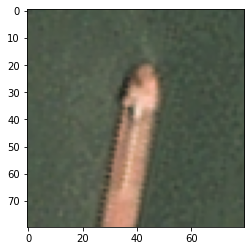

In [316]:
# not sure why a lot of these failed

x, y = actual_coordinates[0]
window = scene_np[y:y+window_height, x:x+window_width]
print(f'({x}, {y})', model.predict(np.array([window])))
plt.imshow(window)